# Multi-Directional Wake Simulation (0°, 30°, 60°, 90°)


In [63]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

# Detect notebook working directory
notebook_cwd = os.getcwd()

# Project root = one level up from notebooks/
project_root = os.path.abspath(os.path.join(notebook_cwd, ".."))

# Add project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import modules
from src.turbine import Turbine
from src.wake_model import velocity_deficit, is_in_wake


In [64]:
def rotate_point(x, y, theta_deg):
    """
    Rotate point (x, y) by theta degrees counterclockwise.
    """
    theta = np.radians(theta_deg)
    xr = x * np.cos(theta) - y * np.sin(theta)
    yr = x * np.sin(theta) + y * np.cos(theta)
    return xr, yr


def rotate_turbines(turbines, theta_deg):
    """
    Rotate all turbines by theta degrees.
    """
    rotated = []
    for t in turbines:
        xr, yr = rotate_point(t.x, t.y, theta_deg)
        rotated.append(Turbine(xr, yr, t.D, t.C_T, t.rated_power_kw))
    return rotated


In [65]:
# Load turbine specs
data_path = os.path.join(project_root, "data", "turbine_specs.json")
with open(data_path, "r") as f:
    specs = json.load(f)

D = specs["rotor_diameter"]
C_T = specs["thrust_coefficient"]
P_rated = specs["rated_power_kw"]

# Spacing: 5D
spacing = 5 * D

base_turbines = []
for i in range(3):
    for j in range(3):
        x = i * spacing
        y = j * spacing
        base_turbines.append(Turbine(x, y, D, C_T, P_rated))

base_turbines


In [66]:
def effective_speed(t, turbines, U_inf, k):
    deficits = []
    for u in turbines:
        if u.x >= t.x:
            continue
        if is_in_wake(t.x, t.y, u.x, u.y, u.R, k):
            dx = t.x - u.x
            dU = velocity_deficit(dx, U_inf, u.C_T, u.R, k) * U_inf
            deficits.append(dU)
    if not deficits:
        return U_inf
    return max(U_inf - np.sqrt(np.sum(np.array(deficits)**2)), 0.0)


In [67]:
def compute_power_for_direction(theta_deg, U_inf=8.0, k=0.04):
    # Rotate turbines so wind is always from +x direction
    turbines = rotate_turbines(base_turbines, theta_deg)

    total_power = 0.0
    for t in turbines:
        U_eff = effective_speed(t, turbines, U_inf, k)
        P = min(P_rated, P_rated * (U_eff / U_inf)**3)
        total_power += P

    return total_power


In [68]:
directions = [0, 30, 60, 90]
powers = [compute_power_for_direction(theta) for theta in directions]
powers




[np.float64(15042.272173917632),
 np.float64(24629.23602915997),
 np.float64(24629.23602915997),
 np.float64(15042.272173917634)]

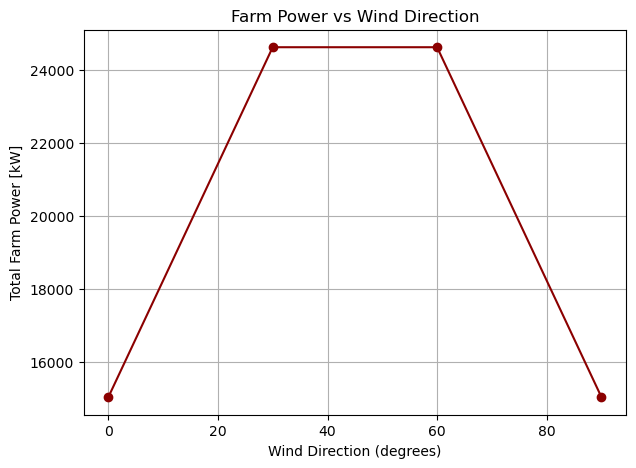

In [69]:
plt.figure(figsize=(7,5))
plt.plot(directions, powers, marker="o", color="darkred")

plt.xlabel("Wind Direction (degrees)")
plt.ylabel("Total Farm Power [kW]")
plt.title("Farm Power vs Wind Direction")
plt.grid(True)

results_dir = os.path.join(project_root, "results")
os.makedirs(results_dir, exist_ok=True)

plt.savefig(os.path.join(results_dir, "power_vs_wind_direction.png"),
            dpi=300, bbox_inches="tight")
plt.show()


In [70]:
wake_map_dir = os.path.join(project_root, "results", "directional_wake_maps")
os.makedirs(wake_map_dir, exist_ok=True)
wake_map_dir


'c:\\Users\\Admin\\computational-research-portfolio\\wind-farm\\project-2-wake-effects\\results\\directional_wake_maps'

In [71]:
def compute_wake_field(turbines, U_inf=8.0, k=0.04, nx=200, ny=200):
    # Determine grid bounds based on turbine positions
    xs_t = [t.x for t in turbines]
    ys_t = [t.y for t in turbines]

    x_min = min(xs_t) - 2 * D
    x_max = max(xs_t) + 8 * D
    y_min = min(ys_t) - 2 * D
    y_max = max(ys_t) + 2 * D

    xs = np.linspace(x_min, x_max, nx)
    ys = np.linspace(y_min, y_max, ny)

    U_field = np.zeros((ny, nx))

    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            deficits = []
            for u in turbines:
                if u.x >= x:
                    continue
                if is_in_wake(x, y, u.x, u.y, u.R, k):
                    dx = x - u.x
                    dU = velocity_deficit(dx, U_inf, u.C_T, u.R, k) * U_inf
                    deficits.append(dU)

            if deficits:
                U_field[i, j] = max(U_inf - np.sqrt(np.sum(np.array(deficits)**2)), 0.0)
            else:
                U_field[i, j] = U_inf

    return xs, ys, U_field


In [72]:
def plot_wake_map(turbines, xs, ys, U_field, theta_deg, save_dir):
    X, Y = np.meshgrid(xs, ys)

    fig, ax = plt.subplots(figsize=(8, 6))  # Explicit figure and axis

    contour = ax.contourf(X, Y, U_field, levels=30, cmap="viridis")
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label("Wind Speed [m/s]")

    tx = [t.x for t in turbines]
    ty = [t.y for t in turbines]
    ax.scatter(tx, ty, c="red", edgecolors="black", zorder=3)

    for i, t in enumerate(turbines):
        ax.text(t.x + 0.1 * D, t.y + 0.1 * D, f"T{i+1}", color="white", fontsize=8)

    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")
    ax.set_title(f"Wake Map for Wind Direction {theta_deg}°")

    save_path = os.path.join(save_dir, f"wake_map_{theta_deg}deg.png")
    fig.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close(fig)


In [73]:
for theta in directions:
    # Rotate turbines
    turbines_rot = rotate_turbines(base_turbines, theta)

    # Compute wake field
    xs, ys, U_field = compute_wake_field(turbines_rot)

    # Plot and save
    plot_wake_map(turbines_rot, xs, ys, U_field, theta, wake_map_dir)

theta, "Done"


(90, 'Done')